
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



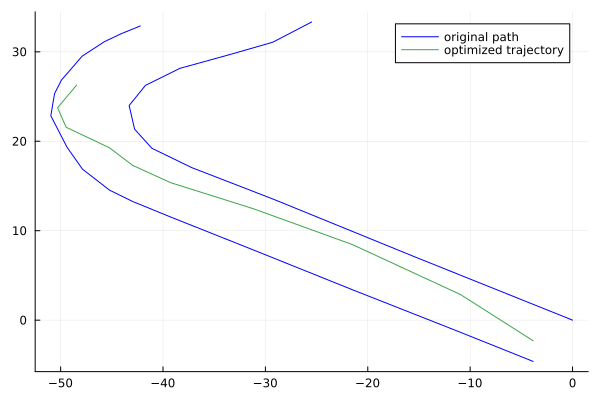

In [1]:
using CSV, JuMP, Ipopt, DelimitedFiles, LinearAlgebra, Plots, StatsPlots

# Read data from CSV files
left_boundary = readdlm("input_trajectory1.csv", ',', Float64)
right_boundary = readdlm("input_trajectory2.csv", ',', Float64)

# Extract x and y values
using JuMP, Ipopt, CSV

# Read in data from CSV files


# Define a JuMP model
model = Model(Ipopt.Optimizer)
set_silent(model)
# Define variables
@variable(model, x[1:10])
@variable(model, y[1:10])

for i = :9
    # Ensure the trajectory is smooth
    @NLconstraint(model, (x[i+1]-x[i])*(y[i]-y[i-1]) - (x[i]-x[i-1])*(y[i+1]-y[i]) >= 0)
end
# Define objective function
@NLobjective(model, Min, sum(((left_boundary[i,1] + right_boundary[i,1]) - x[i])^2 + ((left_boundary[i,2] + right_boundary[i,2]) - y[i])^2 for i=1:10))
@NLobjective(model, Min, sum((left_boundary[i,2] - y[i])^2 + (right_boundary[i,2] - y[i])^2 for i=1:10))
# Define constraints



# Set initial guess
for i = 1:10
        set_start_value(x[i], left_boundary[i,1])
        set_start_value(y[i], left_boundary[i, 2])
     
    
end

# Solve the optimization problem
optimize!(model)

# Print the optimal solution

x_opt = value.(x)
y_opt = value.(y)
plot(left_boundary[:,1], left_boundary[:,2], label="original path", c=:blue)
plot!(right_boundary[:,1], right_boundary[:,2], c=:blue, label = nothing)
plot!(x_opt, y_opt, label="optimized trajectory")

In [ ]:
data = readdlm("input_trajectory.csv", ',', Float64)
x_ref = data[:,1]
y_ref = data[:,2]
theta_ref = zeros(length(x_ref))
for i in 1:length(x_ref)-1
    theta_ref[i] = pi + atan(y_ref[i+1]-y_ref[i], x_ref[i+1]-x_ref[i])
    
end


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref[1]
y_current = y_ref[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x_rect = [x_current]
traj_y_rect = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref, y_ref)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x_rect, x_current)
    push!(traj_y_rect, y_current)

end



In [ ]:
plot(traj_x_rect, traj_y_rect, label = "Actual Trajectory")
plot!(x_ref, y_ref, label = "Reference Trajectory")